In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

The code block below defines a few helper functions to visualize the results. You do not need to touch them. 

In [3]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue). 

In [4]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("TRAIN: images, shape = ", x_train.shape)
print("TRAIN: labels, shape = ", y_train.shape)
print("TEST: images, shape = ", x_test.shape)
print("TEST: labels, shape = ", y_test.shape)

cifar10_labels = np.array([                                                                                                                                                                       
    'airplane',                                                                                                                                                                                   
    'automobile',                                                                                                                                                                                 
    'bird',                                                                                                                                                                                       
    'cat',                                                                                                                                                                                        
    'deer',                                                                                                                                                                                       
    'dog',                                                                                                                                                                                        
    'frog',                                                                                                                                                                                       
    'horse',                                                                                                                                                                                      
    'ship',                                                                                                                                                                                       
    'truck'])  

170498071/170498071 [==============================] - 4s 0us/step
TRAIN: images, shape =  (50000, 32, 32, 3)
TRAIN: labels, shape =  (50000, 1)
TEST: images, shape =  (10000, 32, 32, 3)
TEST: labels, shape =  (10000, 1)


(<Figure size 720x720 with 100 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89dc227450>)

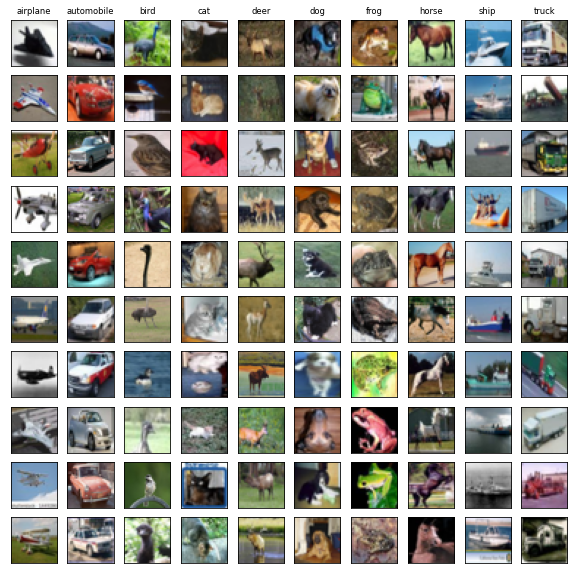

In [5]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [6]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
# Hint: use 20% of the testing data for validation

x_train_norm = x_train / 255.0
x_valid_norm = x_test[8000:] / 255.0
x_test_norm = x_test[:8000] / 255.0


In [11]:
print(cifar10_labels)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


## Normalization

Here we simply normalise the input by dividing by 255 in order to have values ranging between 0 and 1

We start with a fully connected network

In [7]:
# ----------------------------------------------------------
# Define model
# ----------------------------------------------------------
model = tf.keras.models.Sequential(
    [
        # this time the flatten operation is directly integrated into the network 
        # structure so that we can use the same input data later for a convolutional neural network.
        layers.Flatten(input_shape=(32, 32, 3)),  # (32,32,3) --> (3072)
        layers.Dense(256, activation = 'ReLU', input_shape=(3072,)),
        layers.Dropout(0.3),
        layers.Dense(256, activation = 'ReLU'),
        layers.Dense(10, activation = 'softmax')],
    name="nn",
)

print(model.summary())

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

model.fit(
    x_train_norm, y_train_onehot,
    batch_size=64,
    epochs=20, # train at least for 20 epochs
    verbose=2,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
782/782 - 10s - loss: 2.0027 - accuracy: 0.2621 - val_loss: 1.8738 - val_accuracy: 0.3250 - 10s/epoch - 12ms/step
Epoch 2/20
782/782 - 8s - loss: 1.8785 - accuracy: 0.3120 - val_loss: 1.7832 - val_accuracy: 0.3515 - 8s/epoch - 11ms/step
Epoch 3/20
782/782 - 8s - loss: 1.8287 - accuracy: 0.3298 - val_loss: 1.7734 - val_accuracy: 0.3545 - 8s/epoch - 11ms/step
Epoch 4/20
782/782 - 8s - loss: 1.8034 - accuracy: 0.3413 - val_loss: 1.7166 - val_accuracy: 0.3900 - 8s/epoch - 11ms/step
Epoch 5/20
782/782 - 8s - loss: 1.7750 - accuracy: 0.3513 - val_loss: 1.7151 - val_accuracy: 0.3950 - 8s/epoch - 10ms/step
Epoch 6/20
782/782 - 9s - loss: 1.7572 - accuracy: 0.3578 - val_loss: 1.7014 - val_accuracy: 0.4015 - 9s/epoch - 11ms/step
Epoch 7/20
782/782 - 8s - loss: 1.7418 - accuracy: 0.3664 - val_loss: 1.6611 - val_accuracy: 0.4030 - 8s/epoch - 11ms/step
Epoch 8/20
782/782 - 12s - loss: 1.7303 - accuracy: 0.3692 - val_loss: 1.6783 - val_accuracy: 0.4130 - 12s/epoch - 15ms/step
Epoch 9/20
7

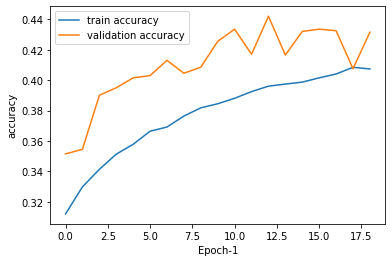

1563/1563 [==============================] - 7s 5ms/step - loss: 1.5670 - accuracy: 0.4662
accuracy for train dataset after training is 0.4662199914455414
63/63 [==============================] - 0s 5ms/step - loss: 1.6187 - accuracy: 0.4315
accuracy for val dataset after training is 0.43149998784065247
250/250 [==============================] - 1s 5ms/step - loss: 1.6037 - accuracy: 0.4457
accuracy for test dataset after training is 0.44574999809265137
63/63 [==============================] - 1s 8ms/step


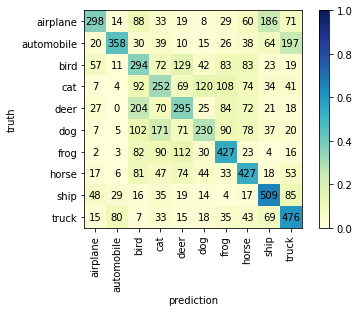

In [9]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves plot
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

train_acc = history["accuracy"][1:]
val_acc = history["val_accuracy"][1:]

plt.plot(train_acc, label = 'train accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("accuracy")
plt.show()

# quote accuracies
print("accuracy for train dataset after training is", model.evaluate(x_train_norm, y_train_onehot)[1])
print("accuracy for val dataset after training is", model.evaluate(x_valid_norm, y_valid_onehot)[1])
print("accuracy for test dataset after training is", model.evaluate(x_test_norm, y_test_onehot)[1])

# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

In [10]:
print(y_test_cl.shape)
print(y_predict_cl.shape)

(8000,)
(8000,)


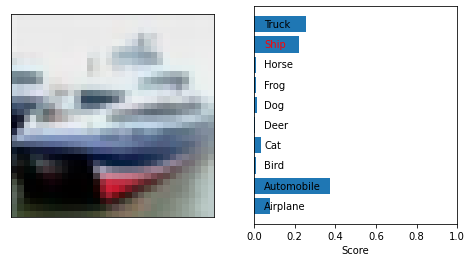

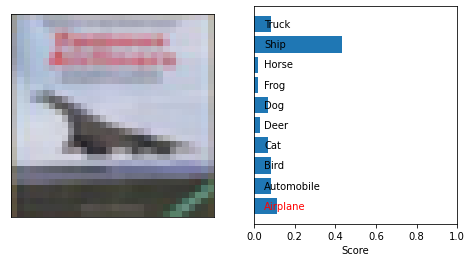

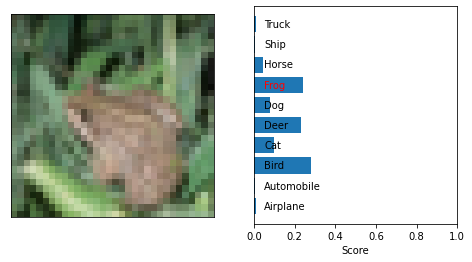

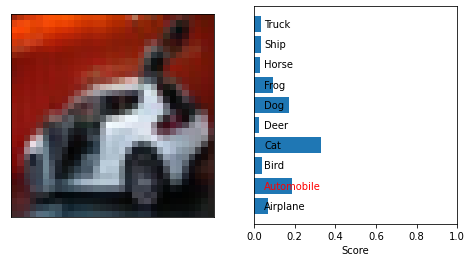

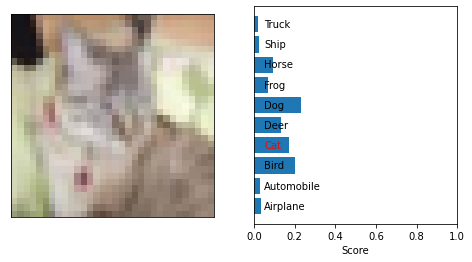

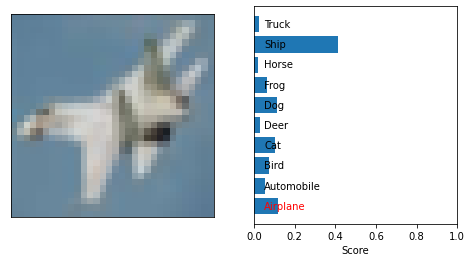

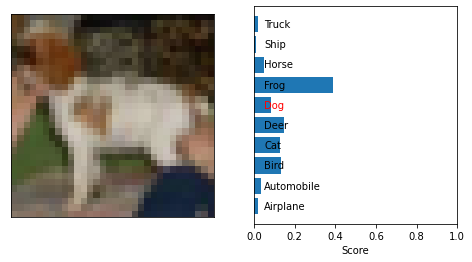

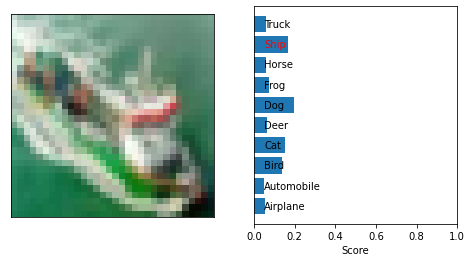

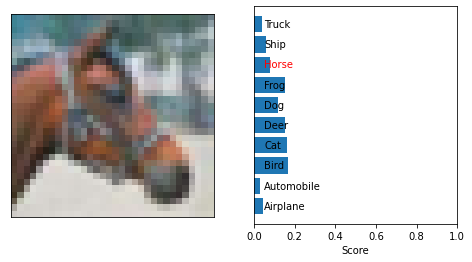

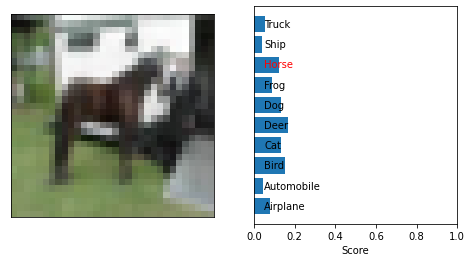

In [ ]:
# Task: plot a few examples of correctly and incorrectly classified images. 
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

Above,

achieved accuracies on training, validation and test dataset are given. Additionally, the confusion matrix of the test dataset is shown. Finally, the accuracy evolution of the train and validation dataset during training is plotted. 

**CNN**
In the second part of this exercise, classify the images with a CNN.


In [ ]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see 
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(10, activation = 'softmax')
    ],
    name="cnn",
)

print(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0       

In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy'])

model.fit(
    x_train_norm, y_train_onehot,
    batch_size=64,
    epochs=20,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
782/782 [==============================] - 48s 61ms/step - loss: 0.9137 - accuracy: 0.6841 - val_loss: 0.9244 - val_accuracy: 0.6755
Epoch 2/20
782/782 [==============================] - 47s 60ms/step - loss: 0.8984 - accuracy: 0.6901 - val_loss: 0.9241 - val_accuracy: 0.6800
Epoch 3/20
782/782 [==============================] - 48s 61ms/step - loss: 0.8863 - accuracy: 0.6926 - val_loss: 0.8981 - val_accuracy: 0.6865
Epoch 4/20
782/782 [==============================] - 48s 61ms/step - loss: 0.8757 - accuracy: 0.6971 - val_loss: 0.9070 - val_accuracy: 0.6925
Epoch 5/20
782/782 [==============================] - 47s 60ms/step - loss: 0.8675 - accuracy: 0.7003 - val_loss: 0.8869 - val_accuracy: 0.6945
Epoch 6/20
782/782 [==============================] - 47s 60ms/step - loss: 0.8601 - accuracy: 0.7021 - val_loss: 0.9221 - val_accuracy: 0.6790
Epoch 7/20
782/782 [==============================] - 48s 61ms/step - loss: 0.8447 - accuracy: 0.7058 - val_loss: 0.8710 - val_accuracy:

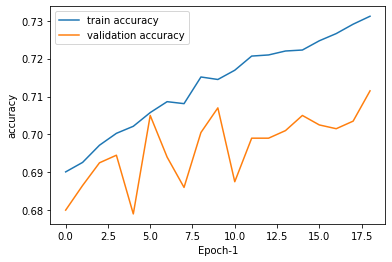

1563/1563 [==============================] - 17s 11ms/step - loss: 0.6490 - accuracy: 0.7791
accuracy for train dataset after training with CNN is 0.7791200280189514
63/63 [==============================] - 1s 11ms/step - loss: 0.8443 - accuracy: 0.7115
accuracy for val dataset after training with CNN is 0.7114999890327454
250/250 [==============================] - 3s 11ms/step - loss: 0.8264 - accuracy: 0.7190
accuracy for test dataset after training with CNN is 0.718999981880188
63/63 [==============================] - 2s 31ms/step


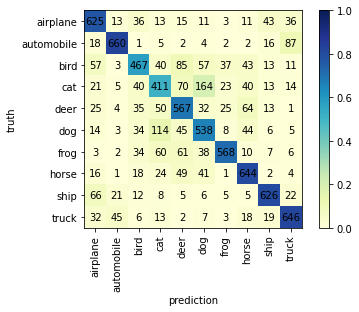

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves plot
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

train_acc = history["accuracy"][1:]
val_acc = history["val_accuracy"][1:]

plt.plot(train_acc, label = 'train accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("accuracy")
plt.show()

# quote accuracies
print("accuracy for train dataset after training with CNN is", model.evaluate(x_train_norm, y_train_onehot)[1])
print("accuracy for val dataset after training with CNN is", model.evaluate(x_valid_norm, y_valid_onehot)[1])
print("accuracy for test dataset after training with CNN is", model.evaluate(x_test_norm, y_test_onehot)[1])

# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

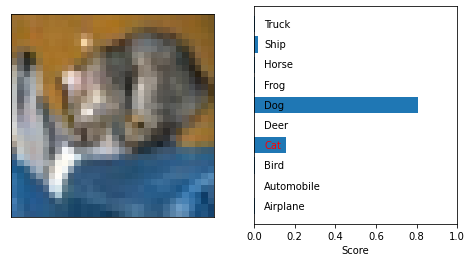

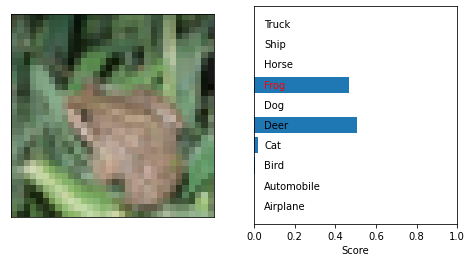

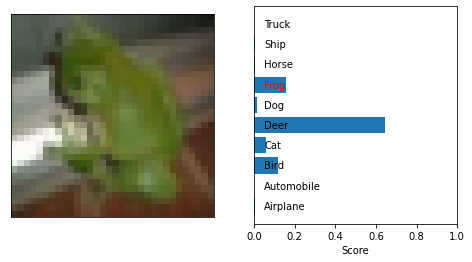

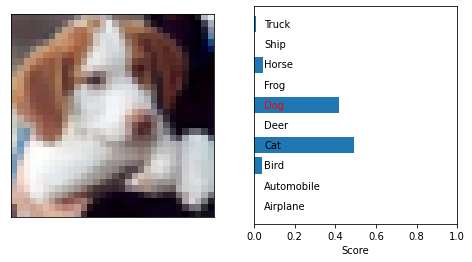

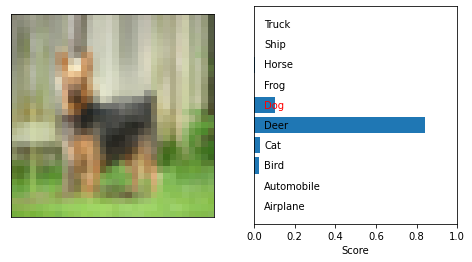

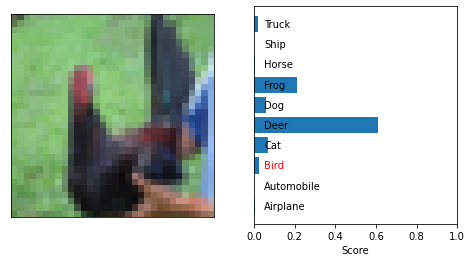

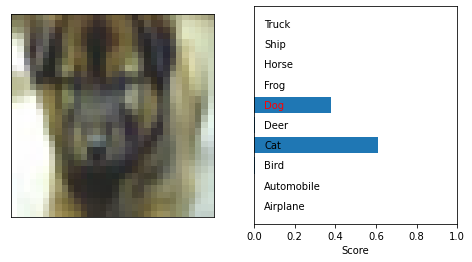

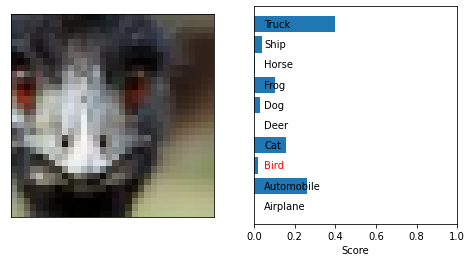

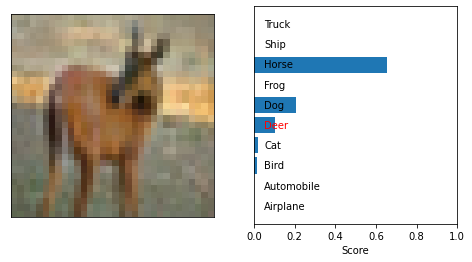

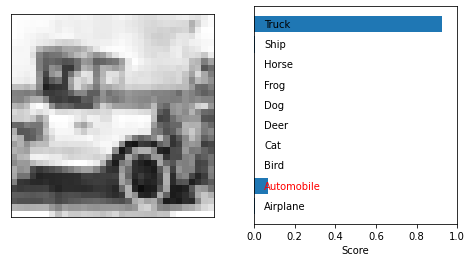

In [ ]:
# Task: plot a few examples of correctly and incorrectly classified images. 
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

Above, using a CNN,

achieved accuracies on training, validation and test dataset are given. Additionally, the confusion matrix of the test dataset is shown. Finally, the accuracy evolution of the train and validation dataset during training is plotted.

One can observe that overall performance of classification, using CNN is much better than a standard DNN, taking into account that we ran only 20 epochs for processing time reasons whereas the accuracy was steadily increasing with the number of epoch.